In [159]:
# Import libraries
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import json
import requests as req
import matplotlib.ticker as mtick

In [4]:
# Import Brazilian egg production time series from the Brazilian Central Bank
# Time Series Management System
ts = pd.read_csv('STP-20221208144657190.csv', sep=';')
ts

,Data,1310 - Quantidade de ovos produzida - D�zias (mil)
0,01/1989,98.191
1,02/1989,92.070
2,03/1989,100.521
3,04/1989,99.336
4,05/1989,103.325
...,...,...
383,12/2020,334.249
384,01/2021,330.138
385,02/2021,308.026
386,03/2021,340.086


In [5]:
# Clear row that says what is the source of the data
ts = ts.loc[ts.Data != 'Fonte'].copy()

# Replace column names
ts.columns = ['date', 'eggs_dozens_k']

# Convert columns
ts['date'] = pd.to_datetime(ts['date'])
ts['eggs_dozens_k'] = pd.to_numeric(ts['eggs_dozens_k'])

# Get month
ts['month'] = ts['date'].dt.month

# Set date column as index
ts = ts.set_index("date")
ts

,eggs_dozens_k,month
date,,
1989-01-01,98.191,1
1989-02-01,92.070,2
1989-03-01,100.521,3
1989-04-01,99.336,4
1989-05-01,103.325,5
...,...,...
2020-11-01,324.391,11
2020-12-01,334.249,12
2021-01-01,330.138,1


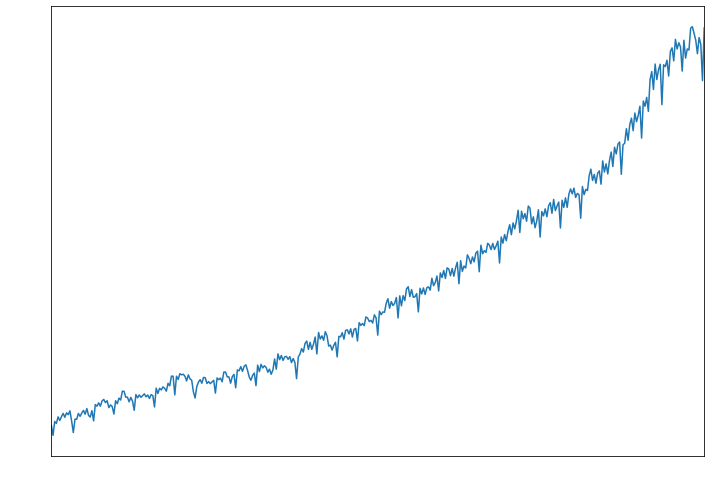

In [6]:
# A4 paper dimensions
a4_dims = (11.7, 8.27)

# Plot
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white'}):
    fig, ax = plt.subplots(figsize=a4_dims)
    _ = ts['eggs_dozens_k'].plot(kind='line')
    plt.ylabel("Thousands of dozens of eggs", {'fontsize' : '14'}, color='white')
    plt.xlabel("Month", {'fontsize' : '14'}, color='white')    

The time series looks non-stationary and it appears to have seasonality. Let's test that.

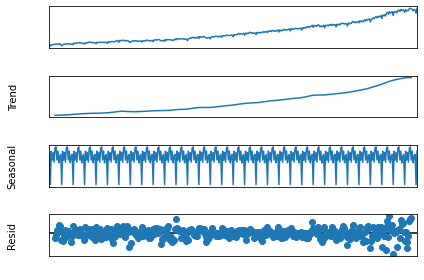

In [7]:
ts_analysis = ts[['eggs_dozens_k']].copy()
# using additive model, because the series appears to have constant crests and troughs
decompose_result_mult = seasonal_decompose(ts_analysis, model="additive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

with plt.rc_context({'xtick.color':'white', 'ytick.color':'white'}):
    decompose_result_mult.plot()

In [8]:
# Monthly averages for the seasonal component
df = pd.DataFrame(seasonal)
df['month'] = df.index
df['month'] = df['month'].dt.month
df

,seasonal,month
date,,
1989-01-01,1.188617,1
1989-02-01,-10.458240,2
1989-03-01,2.447371,3
1989-04-01,-1.019537,4
1989-05-01,1.922908,5
...,...,...
2020-11-01,-2.069469,11
2020-12-01,0.485264,12
2021-01-01,1.188617,1


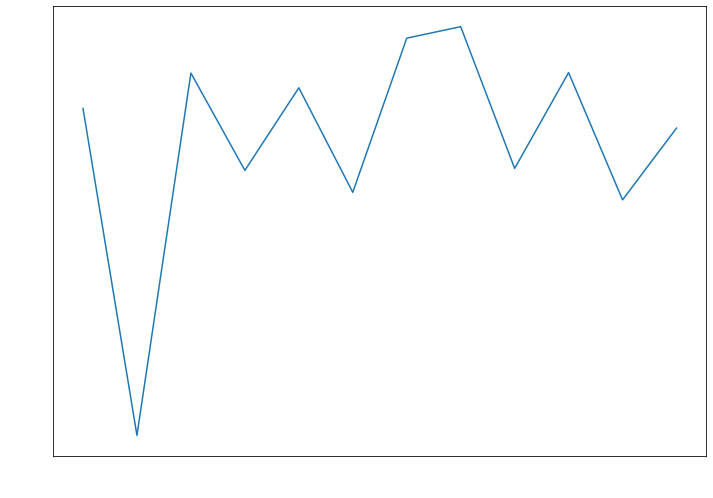

In [9]:
# Monthly averages
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white'}):
    fig, ax = plt.subplots(figsize=a4_dims)
    _ = df.groupby('month').seasonal.mean().plot(kind='line')
    plt.ylabel("Seasonal component average", {'fontsize' : '14'}, color='white')
    plt.xlabel("Month", {'fontsize' : '14'}, color='white')

There's clearly a trough in February.

In [14]:
# ADF Test
result = adfuller(ts['eggs_dozens_k'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: 1.3593155869901108
p-value: 0.9969212493210291


Since the null hypothesis of an Augmented Dickey-Fuller unit root test is that the series has a unit root, and since the p-value is very large, we cannot reject the null hypothesis. Therefore, as expected, we have corroborated the hypothesis that the series is non-stationary. Let's get the first difference of the series.

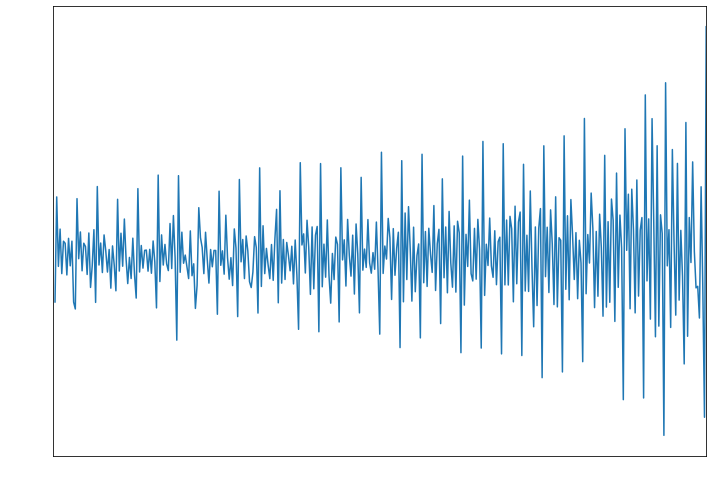

In [16]:
ts['first_diff'] = ts['eggs_dozens_k'].diff()

# Plot
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white'}):
    fig, ax = plt.subplots(figsize=a4_dims)
    _ = ts['first_diff'].plot(kind='line')
    plt.ylabel("First diff - thousands of dozens of eggs", {'fontsize' : '14'}, color='white')
    plt.xlabel("Month", {'fontsize' : '14'}, color='white')    

It looks a bit heteroskedastic, let's use percent difference.

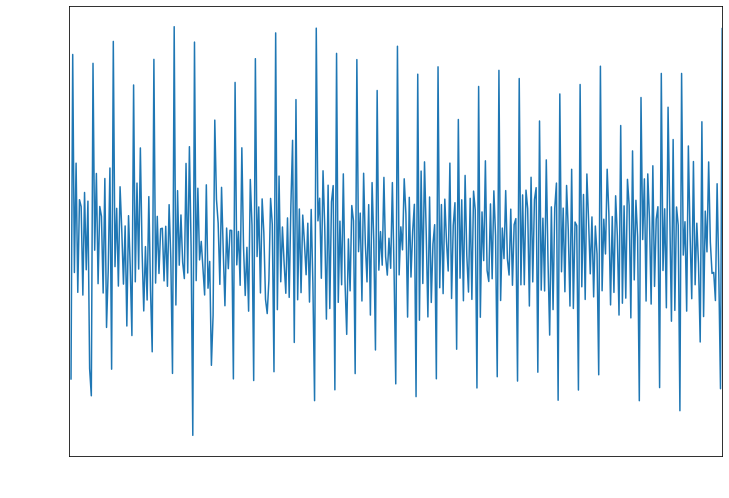

In [18]:
ts['first_diff_pct'] = ts['eggs_dozens_k'].pct_change()

# Plot
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white'}):
    fig, ax = plt.subplots(figsize=a4_dims)
    _ = ts['first_diff_pct'].plot(kind='line')
    plt.ylabel("Percent change - thousands of dozens of eggs", {'fontsize' : '14'}, color='white')
    plt.xlabel("Month", {'fontsize' : '14'}, color='white')    

Much better! Now let's use these data in a Vector Autoregression model to forecast egg prices using the consumer price index (IPCA). The next step is to import IPCA data using Brazil's statistical bureau (IBGE) API.

In [20]:
def request_to_data_frame(request):
    df = pd.json_normalize(json.loads(request.content))
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    df.reset_index(inplace=True, drop=True)
    return df

In [43]:
# table 1692: jul/89-dez/90, monthly variation - v 63, eggs - c72 1791
# table 58: jan/91-jul/99, monthly variation - v 63, eggs - c72 1791
# table 655: ago/99-jun/06, monthly variation - v 63, eggs - c3125 7355 
# table 2938: jul/06-dez/11, monthly variation - v 63, eggs - c3125 7355
# table 1419: jan/12-dez/19, monthly variation - v 63, eggs - c3125 7355
# table 7060: jan/20- , monthly variation - v 63, eggs - c3125 7355
# n1 = 1 means national data
rq_jul89 = req.get('http://api.sidra.ibge.gov.br/values/t/1692/n1/1/v/63/c72/1791/p/all')
rq_jan91 = req.get('http://api.sidra.ibge.gov.br/values/t/58/n1/1/v/63/c72/1791/p/all')
rq_ago99 = req.get('http://api.sidra.ibge.gov.br/values/t/655/n1/1/v/63/c315/7355/p/all')
rq_jul06 = req.get('http://api.sidra.ibge.gov.br/values/t/2938/n1/1/v/63/c315/7355/p/all')
rq_jan12 = req.get('http://api.sidra.ibge.gov.br/values/t/1419/n1/1/v/63/c315/7355/p/all')
rq_jan20 = req.get('http://api.sidra.ibge.gov.br/values/t/7060/n1/1/v/63/c315/7355/p/all')
l1 = [rq_jul89, rq_jan91, rq_ago99, rq_jul06, rq_jan12, rq_jan20]
l2 = [request_to_data_frame(i) for i in l1]

In [70]:
df1 = pd.concat(l2)
df1["Mês (Código)"] = pd.to_datetime(df1["Mês (Código)"], format="%Y%m")
df1 = df1[["Mês (Código)", "Valor"]]
df1.columns = ['date', 'egg_inflation_rate']
df1['egg_inflation_rate'] = pd.to_numeric(df1['egg_inflation_rate'])
df1['month'] = df1['date'].dt.month
df1

,date,egg_inflation_rate,month
0,1989-07-01,-5.35,7
1,1989-08-01,20.80,8
2,1989-09-01,1.83,9
3,1989-10-01,6.34,10
4,1989-11-01,47.12,11
...,...,...,...
29,2022-06-01,-0.57,6
30,2022-07-01,0.42,7
31,2022-08-01,0.96,8
32,2022-09-01,1.68,9


In [71]:
# Join data frames
ts.reset_index(drop=False, inplace=True)
df2 = ts.merge(df1, on=['date','month'])
df2['first_diff_pct'] = df2['first_diff_pct'] * 100
df2 = df2.set_index("date")
df2

,eggs_dozens_k,month,first_diff,first_diff_pct,egg_inflation_rate
date,,,,,
1989-07-01,103.439,7,2.306,2.280166,-5.35
1989-08-01,105.456,8,2.017,1.949942,20.80
1989-09-01,103.082,9,-2.374,-2.251176,1.83
1989-10-01,105.786,10,2.704,2.623154,6.34
1989-11-01,104.677,11,-1.109,-1.048343,47.12
...,...,...,...,...,...
2020-11-01,324.391,11,-8.350,-2.509459,2.22
2020-12-01,334.249,12,9.858,3.038925,1.79
2021-01-01,330.138,1,-4.111,-1.229921,-0.30


Finally, let's look at the percent change in egg quantities and percent change in egg prices (inflation).

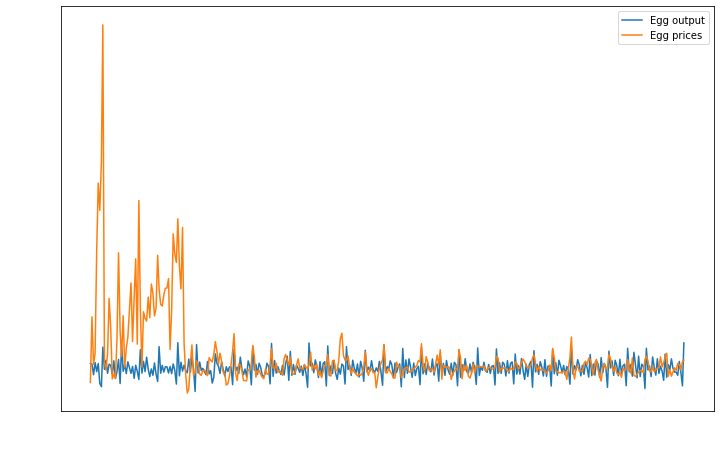

In [74]:
# Plot
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white'}):
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    _ = df2['first_diff_pct'].plot(kind='line', label='Egg output')
    _ = df2['egg_inflation_rate'].plot(kind='line', label='Egg prices')
    plt.ylabel("Percent change", {'fontsize' : '14'}, color='white')
    plt.xlabel("Month", {'fontsize' : '14'}, color='white')
    plt.legend()

Brazil had hyperinflation till 1994, so let's ignore that period.

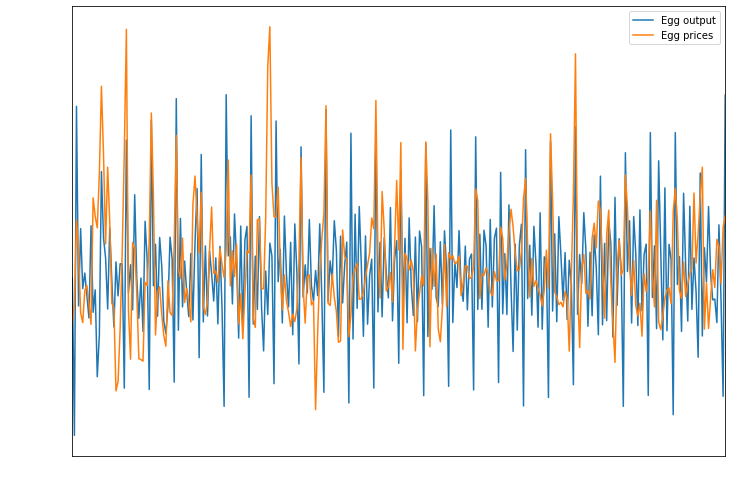

In [76]:
df3 = df2.loc['1995-01-01':].copy()
# Plot
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white'}):
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    _ = df3['first_diff_pct'].plot(kind='line', label='Egg output')
    _ = df3['egg_inflation_rate'].plot(kind='line', label='Egg prices')
    plt.ylabel("Percent change", {'fontsize' : '14'}, color='white')
    plt.xlabel("Month", {'fontsize' : '14'}, color='white')
    plt.legend()

I'll skip unit root testing for the inflation rate series. As an economist, I can assure you that inflation rate series are rarely non-stationary.

Model estimation

In [102]:
df4 = df3[['first_diff_pct', 'egg_inflation_rate']]
df4.columns = ['first_diff_pct_egg_output', 'egg_inflation_rate']

nobs = 12
df_train, df_test = df4[0:-nobs], df4[-nobs:]

# Check size
print(df_train.shape)  # (303, 2)
print(df_test.shape)  # (12, 2)

(303, 2)
(12, 2)


In [89]:
# Call model
model = VAR(df_train)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [90]:
# Select number of lags
x = model.select_order(maxlags=13)
x.summary() # 12 lags is the optimal

,AIC,BIC,FPE,HQIC
0,4.868,4.894,130.1,4.878
1,4.127,4.203,62.00,4.157
2,3.900,4.027,49.43,3.951
3,3.919,4.096,50.34,3.990
4,3.760,3.988,42.96,3.852
5,3.696,3.975,40.30,3.808
6,3.665,3.994,39.07,3.797
7,3.495,3.875,32.97,3.647
8,3.481,3.912,32.51,3.654
9,3.480,3.961,32.46,3.672


In [91]:
model_fitted = model.fit(12)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 08, Dec, 2022
Time:                     20:36:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.25715
Nobs:                     291.000    HQIC:                   2.87884
Log likelihood:          -1157.90    FPE:                    13.8300
AIC:                      2.62599    Det(Omega_mle):         11.7283
--------------------------------------------------------------------
Results for equation first_diff_pct_egg_output
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                 0.619923         0.221054            2.804           0.005
L1.first_diff_pct_egg_output         -0.298101         0.049360          

Forecasting

In [111]:
# Input data for forecasting
forecast_input = df_test.values
forecast_input

array([[-3.27126548,  6.31      ],
       [ 1.73819522, -2.88      ],
       [-0.198286  , -0.26      ],
       [ 4.07431671, -2.84      ],
       [ 0.2620858 , -1.11      ],
       [-1.22192363,  0.49      ],
       [-1.17318253, -0.52      ],
       [-2.50945931,  2.22      ],
       [ 3.03892525,  1.79      ],
       [-1.22992141, -0.3       ],
       [-6.69780516,  2.89      ],
       [10.40821229,  3.55      ]])

In [114]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_test.index, columns=df_test.columns + '_hat')
df_forecast

,first_diff_pct_egg_output_hat,egg_inflation_rate_hat
date,,
2020-04-01,-3.291909,0.220145
2020-05-01,1.873298,0.920411
2020-06-01,-0.262294,3.382068
2020-07-01,3.142674,0.643853
2020-08-01,0.336282,-0.720905
2020-09-01,-0.880627,-3.055076
2020-10-01,-0.477855,-2.809949
2020-11-01,-1.655854,1.023119
2020-12-01,3.320327,1.216065


Model evaluation

In [130]:
df5 = df_forecast.copy()
df5.reset_index(drop=False, inplace=True)
df6 = df_test.copy()
df6.reset_index(drop=False, inplace=True)
df7 = df3['2020-03-01':][['eggs_dozens_k']].copy()
df7.reset_index(drop=False, inplace=True)
df_evalute = df6.merge(df5, on='date')
df_evalute = df7.merge(df_evalute, on='date', how='left')
df_evalute['egg_output_hat'] = df_evalute['eggs_dozens_k'].iloc[-1] *\
(1 + df_evalute['first_diff_pct_egg_output_hat'].div(100))
df_evalute

,date,eggs_dozens_k,first_diff_pct_egg_output,egg_inflation_rate,first_diff_pct_egg_output_hat,egg_inflation_rate_hat,egg_output_hat
0,2020-03-01,332.593,NaN,NaN,NaN,NaN,NaN
1,2020-04-01,321.713,-3.271265,6.31,-3.291909,0.220145,328.890679
2,2020-05-01,327.305,1.738195,-2.88,1.873298,0.920411,346.456826
3,2020-06-01,326.656,-0.198286,-0.26,-0.262294,3.382068,339.193973
4,2020-07-01,339.965,4.074317,-2.84,3.142674,0.643853,350.773795
5,2020-08-01,340.856,0.262086,-1.11,0.336282,-0.720905,341.229646
6,2020-09-01,336.691,-1.221924,0.49,-0.880627,-3.055076,337.091110
7,2020-10-01,332.741,-1.173183,-0.52,-0.477855,-2.809949,338.460883
8,2020-11-01,324.391,-2.509459,2.22,-1.655854,1.023119,334.454672
9,2020-12-01,334.249,3.038925,1.79,3.320327,1.216065,351.377967


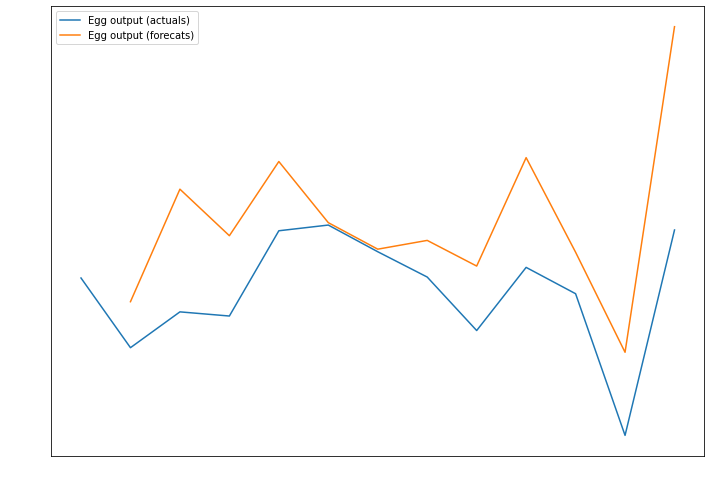

In [133]:
# Plot
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white'}):
    fig, ax = plt.subplots(figsize=a4_dims)
    _ = df_evalute['eggs_dozens_k'].plot(kind='line', label='Egg output (actuals)')
    _ = df_evalute['egg_output_hat'].plot(kind='line', label='Egg output (forecats)')
    plt.ylabel("Thousands of dozens of eggs", {'fontsize' : '14'}, color='white')
    plt.xlabel("", {'fontsize' : '14'}, color='white')
    plt.legend()

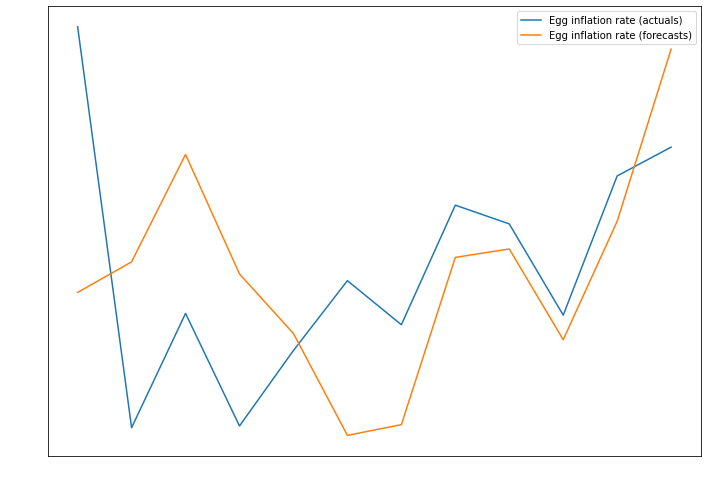

In [134]:
# Plot
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white'}):
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    _ = df_evalute['egg_inflation_rate'].plot(kind='line', label='Egg inflation rate (actuals)')
    _ = df_evalute['egg_inflation_rate_hat'].plot(kind='line', label='Egg inflation rate (forecasts)')
    plt.ylabel("", {'fontsize' : '14'}, color='white')
    plt.xlabel("", {'fontsize' : '14'}, color='white')
    plt.legend()

In [147]:
# Reshape the dataframe to calculate model performance metrics
df_evalute2 = df_evalute.loc[df_evalute['egg_inflation_rate_hat'].notna()].copy()
df_evalute2 = df_evalute2[['date', 'eggs_dozens_k', 'egg_output_hat', 'egg_inflation_rate', 'egg_inflation_rate_hat']]
df_evalute2 = df_evalute2.melt(id_vars='date')
df_evalute2['category'] = 'actuals'
df_evalute2.loc[df_evalute2['variable'].str.contains('hat', regex=False), 'category'] = 'forecast'
df_evalute2['var'] = 'egg output'
df_evalute2.loc[df_evalute2['variable'].str.contains('inflation', regex=False), 'var'] = 'egg inflation rate'
df_evalute2 = df_evalute2.pivot(index=["date", "var"], columns="category", values="value")
df_evalute2.reset_index(inplace=True, drop=False)
df_evalute2

category,date,var,actuals,forecast
0,2020-04-01,egg inflation rate,6.310,0.220145
1,2020-04-01,egg output,321.713,328.890679
2,2020-05-01,egg inflation rate,-2.880,0.920411
3,2020-05-01,egg output,327.305,346.456826
4,2020-06-01,egg inflation rate,-0.260,3.382068
5,2020-06-01,egg output,326.656,339.193973
6,2020-07-01,egg inflation rate,-2.840,0.643853
7,2020-07-01,egg output,339.965,350.773795
8,2020-08-01,egg inflation rate,-1.110,-0.720905
9,2020-08-01,egg output,340.856,341.229646


In [169]:
def mape(df):
    return np.mean(np.abs(df['forecast'] - df['actuals'])/np.abs(df['actuals']))
print('Mean Absolute Percent Error \n')
print(df_evalute2.groupby('var').apply(mape))

Mean Absolute Percent Error 

var
egg inflation rate    2.769887
egg output            0.033983
dtype: float64


In [170]:
def rmse(df):
    return np.mean((df['forecast'] - df['actuals'])**2)**.5
print('Root Mean Squared Errors \n')
print(df_evalute2.groupby('var').apply(rmse))

Root Mean Squared Errors 

var
egg inflation rate     2.93112
egg output            13.95699
dtype: float64
